In [2]:
# =============================================================================
# Predictive Modeling of the Calgary Real Estate Market
#
# Author: Michael Baloun
# Date: November 17, 2025
#
# This notebook details the end-to-end process of building a machine
# learning model to predict residential property assessed values in Calgary.
# =============================================================================

# --- 1. SETUP AND LIBRARIES ---
import pandas as pd
from google.colab import drive
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np
import xgboost as xgb
from shapely.wkt import loads
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Suppress warnings for a clean output
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")

# --- 2. DATA LOADING AND CLEANING ---
print("Preparing data with enhanced granular features...")
drive.mount('/content/drive', force_remount=True)
base_path = '/content/drive/My Drive/ML_Portfolio_Project/data/'
calgary_file = 'Total_Property_Assessed_Value.csv'
calgary_df = pd.read_csv(base_path + calgary_file, low_memory=False)

residential_df = calgary_df[calgary_df['ASSESSMENT_CLASS_DESCRIPTION'] == 'Residential'].copy()

# Clean currency and numeric strings
columns_to_clean = ['ASSESSED_VALUE', 'LAND_SIZE_SM']
for col in columns_to_clean:
    if residential_df[col].dtype == 'object':
        residential_df[col] = residential_df[col].str.replace(',', '')
    residential_df[col] = pd.to_numeric(residential_df[col], errors='coerce')

# Extract Spatial Centroids (Lat/Lon)
def get_centroid(polygon_wkt):
    try:
        polygon = loads(polygon_wkt)
        return polygon.centroid.x, polygon.centroid.y
    except:
        return None, None
centroids = residential_df['MULTIPOLYGON'].apply(get_centroid)
residential_df['longitude'] = centroids.apply(lambda x: x[0])
residential_df['latitude'] = centroids.apply(lambda x: x[1])

# --- UPDATED FEATURE SELECTION ---
# Added 'SUB_PROPERTY_USE' and 'COMM_CODE' based on feature importance analysis
features_to_use = [
    'YEAR_OF_CONSTRUCTION', 'LAND_SIZE_SM', 'ROLL_YEAR',
    'longitude', 'latitude', 'ASSESSED_VALUE',
    'SUB_PROPERTY_USE', 'COMM_CODE'
]

model_df = residential_df[features_to_use].copy()
model_df.dropna(inplace=True)
model_df = model_df[model_df['ASSESSED_VALUE'] < 3000000]

# --- CRITICAL STEP: CATEGORICAL CONVERSION ---
# XGBoost requires object columns to be explicitly cast as 'category' dtype
categorical_cols = ['SUB_PROPERTY_USE', 'COMM_CODE']
for col in categorical_cols:
    model_df[col] = model_df[col].astype("category")

X = model_df.drop('ASSESSED_VALUE', axis=1)
y = model_df['ASSESSED_VALUE']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Data preparation complete. Categorical features enabled.")

Preparing data with enhanced granular features...
Mounted at /content/drive
Data preparation complete. Categorical features enabled.


In [3]:
# --- 3. HYPERPARAMETER TUNING ---
print("Starting hyperparameter tuning... (This will take several minutes)")

# Define the grid of parameters to search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 7, 10],
    'learning_rate': [0.05, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0]
}

# Initialize the XGBoost model
# CRITICAL UPDATE: enable_categorical=True is required for the new features
xgbr = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    device="cuda",
    enable_categorical=True # <--- REQUIRED for SUB_PROPERTY_USE and COMM_CODE
)

# Initialize Randomized Search
random_search = RandomizedSearchCV(
    xgbr,
    param_distributions=param_grid,
    n_iter=10,
    cv=3,
    scoring='r2',
    verbose=1,
    random_state=42
)

# Fit the random search to the data
random_search.fit(X_train, y_train)

# --- 4. EVALUATE THE BEST MODEL ---
print("\nTuning complete.")
print(f"Best Parameters Found: {random_search.best_params_}")

best_model = random_search.best_estimator_
predictions_test = best_model.predict(X_test)
score_r2_test = r2_score(y_test, predictions_test)
score_mae_test = mean_absolute_error(y_test, predictions_test)
score_rmse_test = np.sqrt(mean_squared_error(y_test, predictions_test))

print("\n--- Tuned Model Performance (Test Set) ---")
print(f"R-squared: {score_r2_test:.3f}")
print(f"MAE: ${score_mae_test:,.2f}")
print(f"RMSE: ${score_rmse_test:,.2f}")
print("------------------------------------------")

Starting hyperparameter tuning... (This will take several minutes)
Fitting 3 folds for each of 10 candidates, totalling 30 fits

Tuning complete.
Best Parameters Found: {'subsample': 0.9, 'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.2}

--- Tuned Model Performance (Test Set) ---
R-squared: 0.943
MAE: $41,951.94
RMSE: $80,391.67
------------------------------------------


In [4]:
# --- 5. EVALUATE ON THE TRAINING SET ---

# Use the best_model to make predictions on the data it was trained on
predictions_train = best_model.predict(X_train)

# Calculate the performance metrics for the training set
score_r2_train = r2_score(y_train, predictions_train)
score_mae_train = mean_absolute_error(y_train, predictions_train)
score_rmse_train = np.sqrt(mean_squared_error(y_train, predictions_train))

# Calculate the "Overfitting Gap" (Difference between Train and Test R2)
# Note: distinct from the previous cell's score_r2_test
overfit_gap = score_r2_train - score_r2_test

# Print the training set performance
print("--- Tuned Model Performance (Train Set) ---")
print(f"R-squared: {score_r2_train:.3f}")
print(f"MAE: ${score_mae_train:,.2f}")
print(f"RMSE: ${score_rmse_train:,.2f}")
print(f"Overfit Gap: {overfit_gap:.3f} (Lower is better)")
print("-----------------------------------------")

--- Tuned Model Performance (Train Set) ---
R-squared: 0.953
MAE: $40,069.65
RMSE: $73,332.35
Overfit Gap: 0.010 (Lower is better)
-----------------------------------------


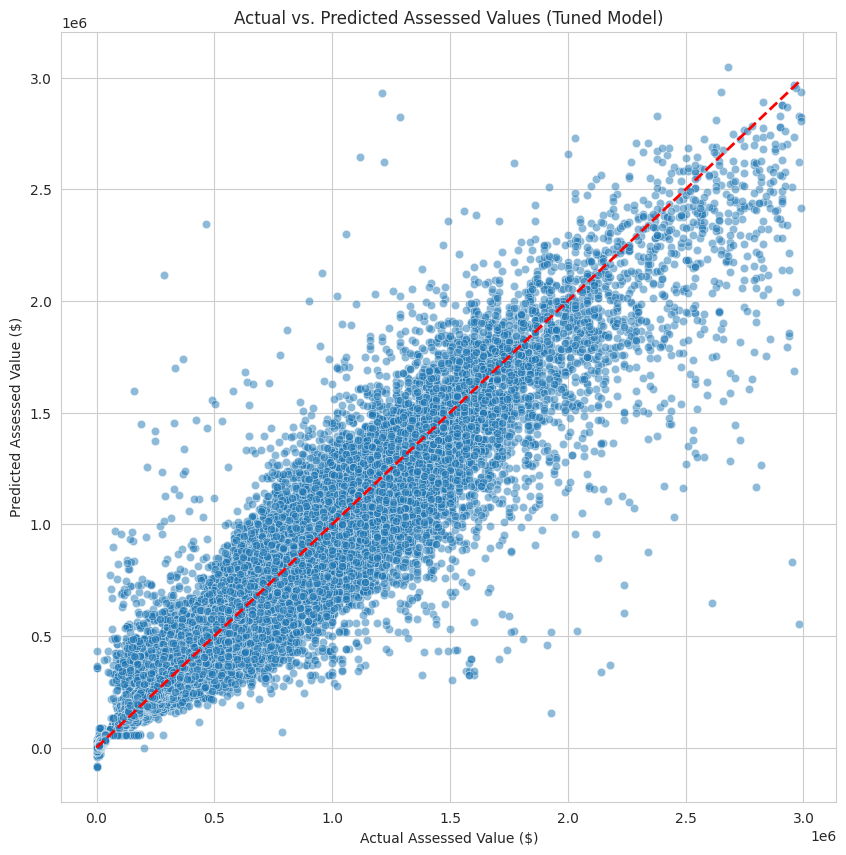

In [13]:
# Plot 1: Actual vs. Predicted Values
plt.figure(figsize=(10, 10))
# Note: uses predictions_test from the cell above
sns.scatterplot(x=y_test, y=predictions_test, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2, linestyle='--')
plt.title('Actual vs. Predicted Assessed Values (Tuned Model)')
plt.xlabel('Actual Assessed Value ($)')
plt.ylabel('Predicted Assessed Value ($)')
plt.show()

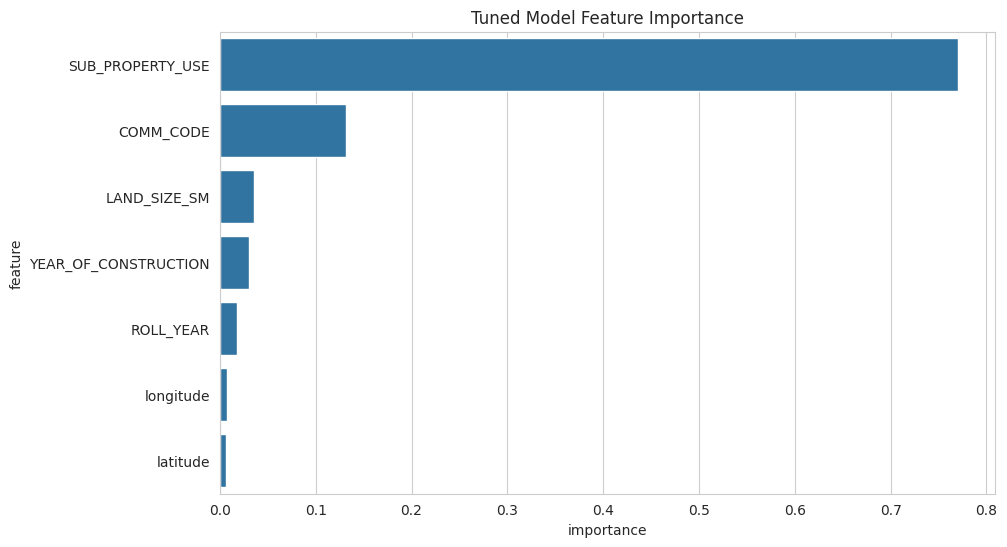

In [6]:
# Plot 2: Feature Importance
# Note: uses best_model from the cell above
importances = best_model.feature_importances_
feature_importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': importances
}).sort_values('importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importances)
plt.title('Tuned Model Feature Importance')
plt.show()

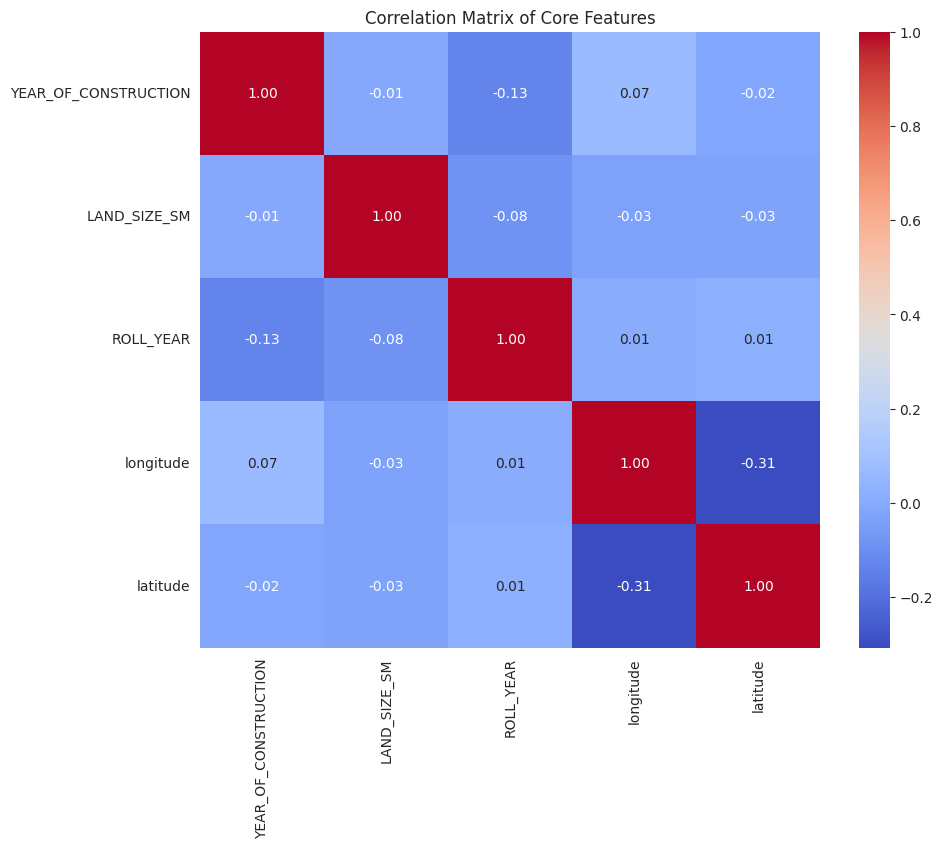

In [10]:
# Plot 3: Correlation Matrix of Features
# Fix: We add 'numeric_only=True' to ignore the new text-based categories
corr_matrix = X.corr(numeric_only=True)

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Core Features')
plt.show()

Generating residual diagnostics...


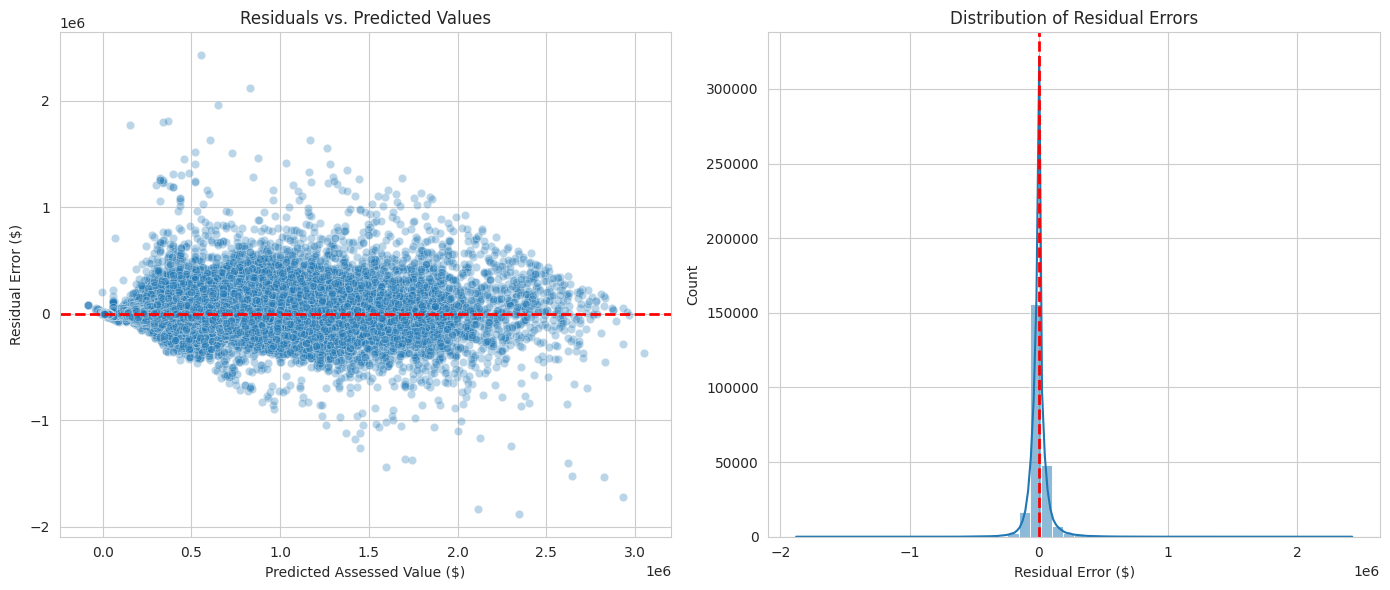


Residual Summary:
Mean Error: $-119.40 (Should be close to 0)
Standard Deviation: $80,391.59


In [11]:
# --- 6. RESIDUAL DIAGNOSTICS ---
print("Generating residual diagnostics...")

plt.figure(figsize=(14, 6))

# Calculate residuals (The "Error" for each prediction)
residuals = y_test - predictions_test

# Plot 1: Residuals vs. Predicted Values (Homoscedasticity Check)
plt.subplot(1, 2, 1)
sns.scatterplot(x=predictions_test, y=residuals, alpha=0.3)
plt.axhline(y=0, color='red', linestyle='--', lw=2)
plt.title('Residuals vs. Predicted Values')
plt.xlabel('Predicted Assessed Value ($)')
plt.ylabel('Residual Error ($)')

# Plot 2: Distribution of Residuals (Normality Check)
plt.subplot(1, 2, 2)
sns.histplot(residuals, kde=True, bins=50)
plt.title('Distribution of Residual Errors')
plt.xlabel('Residual Error ($)')
plt.axvline(x=0, color='red', linestyle='--', lw=2)

plt.tight_layout()
plt.show()

# Print statistical summary of residuals
print("\nResidual Summary:")
print(f"Mean Error: ${np.mean(residuals):,.2f} (Should be close to 0)")
print(f"Standard Deviation: ${np.std(residuals):,.2f}")